In [1]:
from vnstock import *
from vnstock.chart import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import numpy as np

In [3]:
from sklearn.preprocessing import MinMaxScaler


In [53]:
import datetime
today_ = datetime.date.today()
one_year_past_date = str(today_ - datetime.timedelta(days=365*4))
df_VIC  =  stock_historical_data(symbol='VIC', 
                            start_date=str(one_year_past_date), 
                            end_date=str(today_), resolution='1D', type='stock', beautify=True)
df_VIC = df_VIC[['time','close']]
df_VIC.rename(columns={'time':'date','close':'VIC'},inplace=True)
dataset = df_VIC["VIC"]

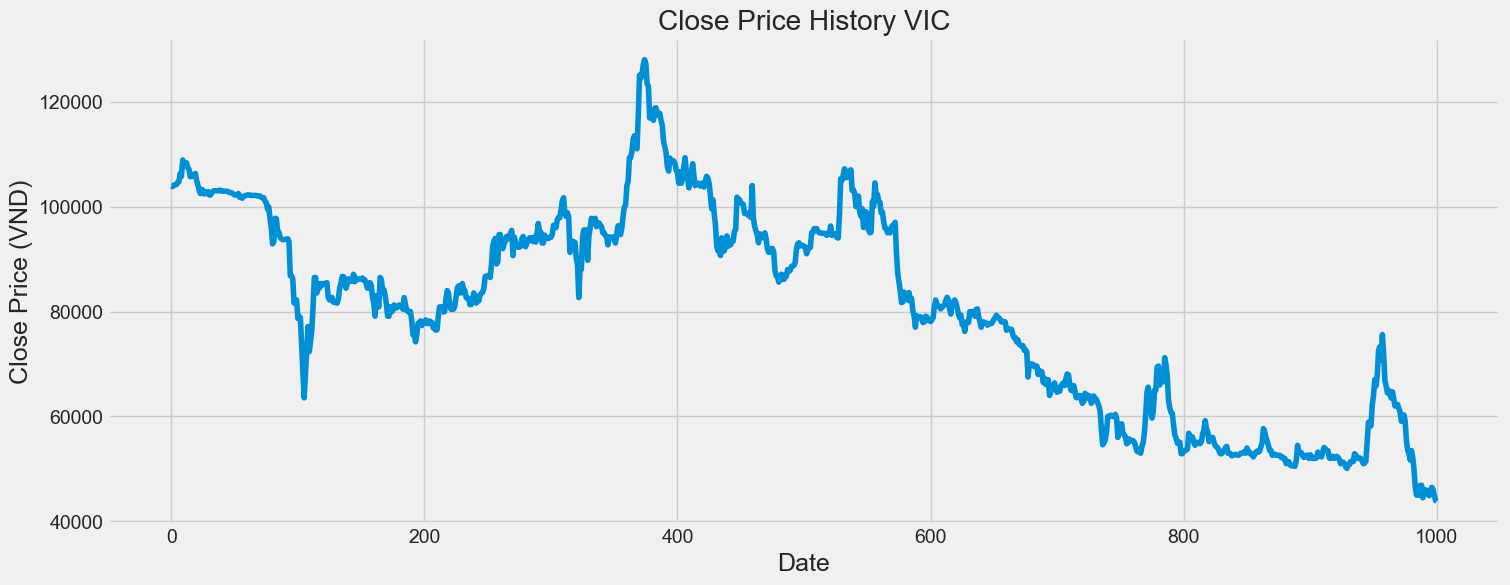

In [54]:
plt.figure(figsize=(16,6))
plt.title('Close Price History VIC')
plt.plot(dataset)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (VND)', fontsize=18)
plt.show()

In [68]:
# Create a new dataframe with only the 'Close column 
data = df_VIC.filter(['VIC'])
data.rename(columns = {"VIC":"close"},inplace=True)
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

951

In [69]:
data

,close
0,103899
1,103810
2,104077
3,104165
4,104165
...,...
996,46500
997,46100
998,45000
999,44000


In [63]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.71389202],
       [0.71283483],
       [0.71600641],
       ...,
       [0.01425432],
       [0.00237572],
       [0.        ]])

In [64]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))

[]


In [70]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape


[array([0.71389202, 0.71283483, 0.71600641, 0.71705173, 0.71705173,
       0.72233771, 0.7233949 , 0.74240067, 0.73605749, 0.77301182,
       0.76456613, 0.76245174, 0.76668053, 0.75506325, 0.75189167,
       0.7350003 , 0.74028627, 0.73605749, 0.73922908, 0.74240067,
       0.72655461, 0.71600641, 0.70438914, 0.69700065, 0.70650353,
       0.70438914, 0.69594346, 0.70016036, 0.70121756, 0.70121756,
       0.69382907, 0.69382907, 0.69911504, 0.70227475, 0.70333195,
       0.70333195, 0.70333195, 0.70333195, 0.70438914, 0.70438914,
       0.70227475, 0.70227475, 0.70227475, 0.70227475, 0.70227475,
       0.70121756, 0.69911504, 0.69911504, 0.69805785, 0.69594346,
       0.69382907, 0.69382907, 0.69382907, 0.69700065, 0.68855497,
       0.69065748, 0.68644058, 0.69065748, 0.69171468, 0.69277187])]
[0.6938290669359151]

[array([0.71389202, 0.71283483, 0.71600641, 0.71705173, 0.71705173,
       0.72233771, 0.7233949 , 0.74240067, 0.73605749, 0.77301182,
       0.76456613, 0.76245174, 0.766

In [71]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

891/891 [==============================] - 23s 23ms/step - loss: 0.0032


In [72]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 15ms/step


3531.2684130468765

C:\Users\USER\AppData\Local\Temp\ipykernel_5916\1567551038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


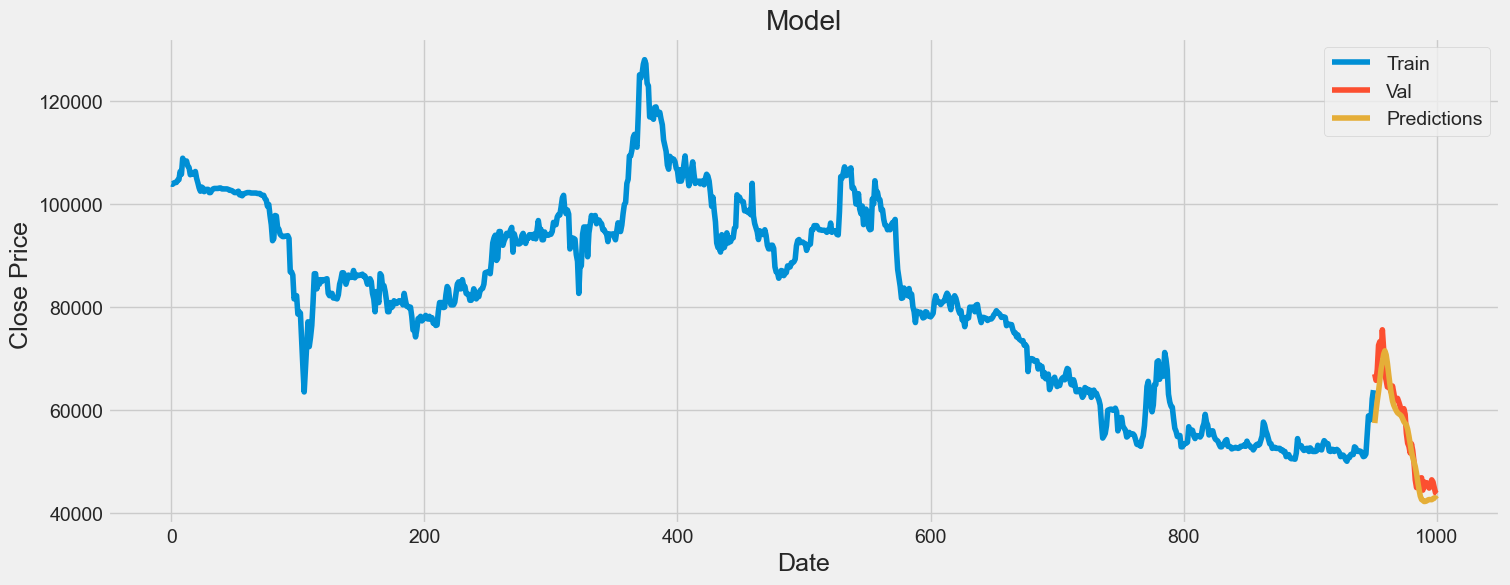

In [77]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()